<a href="https://colab.research.google.com/github/minassy/ISID_2021/blob/main/210918_%E3%83%A2%E3%83%87%E3%83%AA%E3%83%B3%E3%82%B0_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile
import glob
import pandas as pd
import numpy as np
import pathlib
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#作業基本ディレクトリ
DIR = 'drive/MyDrive/00_Competition/ISID/2021'
os.listdir(DIR)
#os.mkdir(DIR+'/data')

['210918_モデリング_LSTM.ipynb',
 'data',
 '210904_学習データの読み込み.ipynb',
 '210906_EDA_train.ipynb',
 '210908_EDA_test.ipynb',
 '210908_テストデータの読み込み_作成.ipynb',
 '210909_特徴量エンジニアリング.ipynb',
 '210912_特徴量E_連続処理_モデル検討_OneClassSVM.ipynb',
 '210916_モデル検討_AE_ペンディング.ipynb',
 '210918_LSTM練習.ipynb',
 '210917_特徴量_手動_の再観察.ipynb']

In [ ]:
DIR_DATA_TRAIN = os.path.join(DIR, 'data', 'Train_Unit_20210903')
DIR_DATA_TEST = os.path.join(DIR, 'data', 'Test_Unit_20210903')

In [ ]:
#一連のデータ処理
def get_some_values(file_path):
  #ファイルパスから、ユニット名を取得。
  dirname = os.path.dirname(file_path)
  dirname_split = dirname.split('/')#区切り文字'/'で分割
  unit = dirname_split[-2]
  charge_mode = dirname_split[-1]
  #ファイルパスから、サイクル数を取得。
  basename = os.path.basename(file_path)
  basename_split = basename.split('_')[4]#区切り文字'_'で分割
  cycle_num = basename_split.split('.')[0]
  return unit, charge_mode, cycle_num

In [ ]:
#%time
#DATA_DIR = DIR_DATA_TRAIN
#DATA_DIR = DIR_DATA_TEST

#C = 'Charge'
#C = 'Discharge'

def data_reading(DATA_DIR, C):

  #カラム名変更前後の辞書
  col_list = {'Time (s)' : 'Time',
              'Voltage Measured (V)' : 'VM',
              'Voltage Charge (V)' : 'VC',
              'Current Measured (Amps)' : 'CM', 
              'Current Charge (Amps)' : 'CC',
              'Temperature (degree C)': 'Temp', 
              'unit' : 'unit_name', 
              'charge_mode' : 'mode', 
              'Cycle_num' : 'Cycle',
              'Voltage Load (V)' : 'VL',
              'Current Load (Amps)' : 'CL'
  }

  df_list = []
  for folder in tqdm(os.listdir(DATA_DIR)[:3]):
    files = glob.glob(os.path.join(DATA_DIR, folder, C, '*.csv'))
    df_list_0 = []
    for file in files:
      tmp_df = pd.read_csv(file, encoding='utf-8')
      tmp_df = tmp_df.rename(columns=col_list)
      #ユニット名、充・放電モード、サイクル数の取得
      unit, charge_mode, cycle_num = get_some_values(file)
      #特徴量のデータフレームの作成
      if C == 'Charge':
        df_exp = pd.DataFrame([{'unit':unit,
                          'charge_mode' : charge_mode,
                          'Cycle_num' : int(cycle_num),
                          'feature_c_vm' : featured_c_vm(tmp_df),
                          'feature_c_cm' : featured_c_cm(tmp_df),
                          'feature_c_vc' : featured_c_vc(tmp_df)}])
      else:
        df_exp = pd.DataFrame([{'unit':unit,
                          'charge_mode' : charge_mode,
                          'Cycle_num' : int(cycle_num),
                          'feature_d_vm' : featured_d_vm(tmp_df),
                          'feature_d_vl' : featured_d_vl(tmp_df)}])
      df_list_0.append(df_exp)
    df_0 = pd.concat(df_list_0)
    df_list.append(df_0)
  df = pd.concat(df_list)

  #ユニットとサイクルでソート。
  df = df.sort_values(['unit', 'Cycle_num'])
  #インデックスの振り直し
  df = df.reset_index(drop=True)

  return df

In [ ]:
def featured_c_vm(df):
  #LAG=5が0.001未満が続くところを、飽和領域とみなす。
  p_c_vm = df.loc[:, 'VM'][df.loc[:, 'VM'].diff(5) < 0.001]
  #飽和領域のなかで、最初の点を点P_C_VMとする。
  p_c_vm = p_c_vm.reset_index(inplace=False)
  p_c_vm = p_c_vm['index'].iloc[0]
  #充電VMの特徴量は、点P_C_VMにおける時間
  feature_c_vm = df['Time'].loc[p_c_vm]
  return feature_c_vm

def featured_c_cm(df):
  #飽和領域からの立ち下がり点(LAG=5の勾配が最小となる点)を点P_C_CMとする。
  p_c_cm = np.gradient(df.loc[:, 'CM'].diff(5)[10:]).argmin()
  #充電CMの特徴量は、点P_C_CMにおける時間
  feature_c_cm = df['Time'].loc[p_c_cm]
  return feature_c_cm

def featured_c_vc(df):
  #VCが最大値を示す点を、点P_C_VCとする。
  p_c_vc = df.VC.argmax()
  #充電VCの特徴量は、点P_C_VCにおける時間
  feature_c_vc = df['Time'].loc[p_c_vc]
  return feature_c_vc

def featured_d_vm(df):
  #VMが最小値を示す点を、点P_D_VMとする。
  p_d_vm = df.VM.argmin()
  #放電VMの特徴量は、点P_D_VMにおける時間
  feature_d_vm = df['Time'].loc[p_d_vm]
  return feature_d_vm

def featured_d_vl(df):
  #VLの最大値点以降の領域において、最小値を示す点を、点P_D_VLとする。
  VL_max = df.VL.argmax()
  p_d_vl = df.VL[VL_max: ].argmin()
  #放電VLの特徴量は、点P_D_VLにおける時間
  feature_d_vl = df['Time'].loc[p_d_vl]
  return feature_d_vl

# 学習データ、テストデータの読み込み

In [ ]:
%time
#データの読み込み(学習)
#充電

DATA_DIR = DIR_DATA_TRAIN
#DATA_DIR = DIR_DATA_TEST

C = 'Charge'
#C = 'Discharge'

df_train_charge = data_reading(DATA_DIR, C)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


100%|██████████| 3/3 [01:15<00:00, 25.04s/it]


In [ ]:
%time
#データの読み込み(学習)
#放電

DATA_DIR = DIR_DATA_TRAIN
#DATA_DIR = DIR_DATA_TEST

#C = 'Charge'
C = 'Discharge'

df_train_discharge = data_reading(DATA_DIR, C)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


100%|██████████| 3/3 [01:16<00:00, 25.44s/it]


In [ ]:
#充電と放電の特徴量のデータセット作成
df_train_feature = pd.merge(df_train_charge, df_train_discharge,
                            how = 'inner',
                            on = ['unit', 'Cycle_num'])
df_train_feature.head()

,unit,charge_mode_x,Cycle_num,feature_c_vm,feature_c_cm,feature_c_vc,charge_mode_y,feature_d_vm,feature_d_vl
0,Train_Unit_1,Charge,1,3422.5,3207.4,3241.8,Discharge,3346.9,3327.2
1,Train_Unit_1,Charge,2,3431.6,3181.8,3262.3,Discharge,3328.8,3309.2
2,Train_Unit_1,Charge,3,3409.1,9692.7,3229.2,Discharge,3309.4,3289.8
3,Train_Unit_1,Charge,4,3407.7,3160.2,3228.2,Discharge,3309.7,3289.9
4,Train_Unit_1,Charge,5,3409.6,3172.4,3217.9,Discharge,3307.7,3287.9


In [ ]:
%time
#データの読み込み(学習)
#充電

#DATA_DIR = DIR_DATA_TRAIN
DATA_DIR = DIR_DATA_TEST

C = 'Charge'
#C = 'Discharge'

df_test_charge = data_reading(DATA_DIR, C)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.82 µs


100%|██████████| 3/3 [00:39<00:00, 13.16s/it]


In [ ]:
%time
#データの読み込み(学習)
#放電

#DATA_DIR = DIR_DATA_TRAIN
DATA_DIR = DIR_DATA_TEST

#C = 'Charge'
C = 'Discharge'

df_test_discharge = data_reading(DATA_DIR, C)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


100%|██████████| 3/3 [00:39<00:00, 13.28s/it]


In [ ]:
#充電と放電の特徴量のデータセット作成
df_test_feature = pd.merge(df_test_charge, df_test_discharge,
                            how = 'inner',
                            on = ['unit', 'Cycle_num'])
df_test_feature.head()

,unit,charge_mode_x,Cycle_num,feature_c_vm,feature_c_cm,feature_c_vc,charge_mode_y,feature_d_vm,feature_d_vl
0,Test_Unit_1,Charge,1,741.86,3476.3,3141.4,Discharge,3338.4,3328.9
1,Test_Unit_1,Charge,2,849.45,3451.6,3164.0,Discharge,3318.3,3308.8
2,Test_Unit_1,Charge,3,803.84,8280.7,3145.7,Discharge,3312.4,3302.7
3,Test_Unit_1,Charge,4,806.83,3102.9,3123.4,Discharge,3296.1,3286.4
4,Test_Unit_1,Charge,5,1004.50,3147.9,3163.0,Discharge,3298.1,3288.2


# 学習データの作成

In [ ]:
import math
from keras.models import Sequential
from keras.layers import Dense

まとめ  
テストユニット1：訓練ユニット1と似ている。 feature_d_vm と feature_d_vm or feature_d_vlで、ほぼ説明できそう。

テストユニット2：訓練ユニット2と似ている。 feature_c_vm と feature_d_vm or feature_d_vlで、ほぼ説明できそう。　　

テストユニット3：訓練ユニット1と似ている。 feature_d_vm feature_d_vl と feature_d_vm feature_d_vlで、ほぼ説明できそう。　

In [ ]:
num_train_unit_1 = 124
num_train_unit_2 = 40
num_train_unit_3 = 97

num_test_unit_1 = 70
num_test_unit_2 = 12
num_test_unit_3 = 55

テストユニット1

In [ ]:
#ラグを定義し、LSTM用のデータセットを作る
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
#学習データと検証データ
train_unit_1 = df_train_feature[df_train_feature['unit'] == 'Train_Unit_1' ].reset_index()
dataset = train_unit_1['feature_d_vm'].values.astype('float32')

In [ ]:
print(dataset.ndim)
print(dataset.shape)
print(dataset.size)

1
(124,)
124


In [ ]:
#次元数の変更
dataset = dataset.reshape(124, 1)
print(dataset.ndim)
print(dataset.shape)
print(dataset.size)

2
(124, 1)
124


In [ ]:
# split into train and test sets
train_size = num_test_unit_1
val_size = len(dataset) - train_size
train, val = dataset[0:train_size], dataset[train_size:len(dataset)]

In [ ]:
# reshape dataset
look_back = 2
trainX, trainY = create_dataset(train, look_back)
valX, valY = create_dataset(val, look_back)

In [ ]:
trainX

array([[3346.9, 3328.8],
       [3328.8, 3309.4],
       [3309.4, 3309.7],
       [3309.7, 3307.7],
       [3307.7, 3309.3],
       [3309.3, 3308.4],
       [3308.4, 3291.5],
       [3291.5, 3289.9],
       [3289.9, 3290.2],
       [3290.2, 3290.2],
       [3290.2, 3271. ],
       [3271. , 3270.8],
       [3270.8, 3270.3],
       [3270.3, 3251.1],
       [3251.1, 3250. ],
       [3250. , 3250.4],
       [3250.4, 3251.1],
       [3251.1, 3250.8],
       [3250.8, 3330. ],
       [3330. , 3331.2],
       [3331.2, 3311.3],
       [3311.3, 3292.5],
       [3292.5, 3291.2],
       [3291.2, 3292.2],
       [3292.2, 3271.3],
       [3271.3, 3272.7],
       [3272.7, 3270.9],
       [3270.9, 3250.9],
       [3250.9, 3253.2],
       [3253.2, 3326.6],
       [3326.6, 3289.2],
       [3289.2, 3270.2],
       [3270.2, 3251.4],
       [3251.4, 3243. ],
       [3243. , 3233.2],
       [3233.2, 3214. ],
       [3214. , 3204.3],
       [3204.3, 3186.4],
       [3186.4, 3185.8],
       [3185.8, 3176.8],


In [ ]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(12, input_dim=look_back, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=2, verbose=2)

Epoch 1/50
34/34 - 0s - loss: 17542146.0000
Epoch 2/50
34/34 - 0s - loss: 13677851.0000
Epoch 3/50
34/34 - 0s - loss: 10561189.0000
Epoch 4/50
34/34 - 0s - loss: 7820663.5000
Epoch 5/50
34/34 - 0s - loss: 5279354.5000
Epoch 6/50
34/34 - 0s - loss: 3362210.5000
Epoch 7/50
34/34 - 0s - loss: 1908918.6250
Epoch 8/50
34/34 - 0s - loss: 831037.3125
Epoch 9/50
34/34 - 0s - loss: 256757.0781
Epoch 10/50
34/34 - 0s - loss: 53001.3945
Epoch 11/50
34/34 - 0s - loss: 7474.5547
Epoch 12/50
34/34 - 0s - loss: 1126.0880
Epoch 13/50
34/34 - 0s - loss: 542.6089
Epoch 14/50
34/34 - 0s - loss: 512.3167
Epoch 15/50
34/34 - 0s - loss: 513.3939
Epoch 16/50
34/34 - 0s - loss: 511.2057
Epoch 17/50
34/34 - 0s - loss: 510.7190
Epoch 18/50
34/34 - 0s - loss: 511.0470
Epoch 19/50
34/34 - 0s - loss: 510.3895
Epoch 20/50
34/34 - 0s - loss: 511.0860
Epoch 21/50
34/34 - 0s - loss: 513.7004
Epoch 22/50
34/34 - 0s - loss: 510.7984
Epoch 23/50
34/34 - 0s - loss: 513.9443
Epoch 24/50
34/34 - 0s - loss: 521.3885
Epoch 25

In [ ]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
valScore = model.evaluate(valX, valY, verbose=0)
print('Validation Score: %.2f MSE (%.2f RMSE)' % (valScore, math.sqrt(valScore)))
# generate predictions for training
trainPredict = model.predict(trainX)
valPredict = model.predict(valX)

Train Score: 508.50 MSE (22.55 RMSE)
Validation Score: 799.05 MSE (28.27 RMSE)


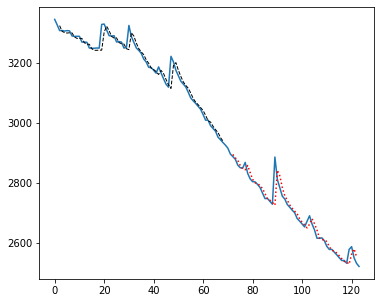

In [ ]:
# shift train predictions for plotting
plt.rcParams['figure.figsize'] = [6, 5]
#datasetと同じ空配列リストを作成
trainPredictPlot = np.empty_like(dataset)
#リストをnanに置き換え
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
valPredictPlot = np.empty_like(dataset)
valPredictPlot[:, :] = np.nan
valPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = valPredict
# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot,linewidth =1, linestyle = '--',color='k')
plt.plot(valPredictPlot,linestyle= ':',color='r')

plt.show()

# テストデータによる推論

学習データ(1～70)で、テストデータ(1～70)を予測するモデルを作成する。  
推論も同様に?  
テストデータでモデル作って、未知部分を予想するタスク？

In [ ]:
#テストデータ
test_unit_1 = df_test_feature[df_test_feature['unit'] == 'Test_Unit_1' ].reset_index()
dataset_test = test_unit_1['feature_d_vm'].values.astype('float32')

In [ ]:
print(dataset_test.ndim)
print(dataset_test.shape)
print(dataset_test.size)

1
(70,)
70


In [ ]:
#次元数の変更
dataset_test = dataset_test.reshape(70, 1)
print(dataset_test.ndim)
print(dataset_test.shape)
print(dataset_test.size)

2
(70, 1)
70


In [ ]:
# reshape dataset
look_back = 2
test = dataset_test
testX, testY = create_dataset(test, look_back)

In [ ]:
testPredict = model.predict(testX)

In [ ]:
testPredict.shape

(67, 1)

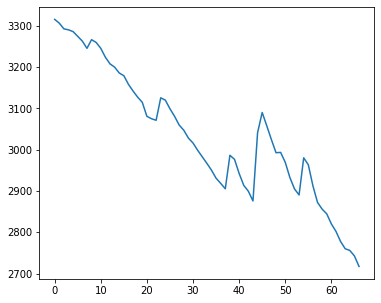

In [ ]:
plt.plot(testPredict)

In [ ]:
testX.ndim

2

In [ ]:
hoge = trainX.shape[0] - 1
future_test = trainX[hoge]
n = testX.shape[0]
test_data = future_test.reshape(2,1)

2

In [ ]:
#テストデータの最終行を取得
hoge = trainX.shape[0] - 1
future_test = trainX[hoge]

#予測結果をy_pred_summary に入れる
y_pred_summary = np.empty((1))
 
n = testX.shape[0]
 
for step in range(n):
    
    #最新のテストデータで予測値を算出
    test_data = future_test.reshape(2,1)
    batch_predict = model.predict(test_data)
    
    #予測値を最新のテストデータにしてテストデータを更新
    future_test = np.delete(future_test, 0)
    future_test = np.append(future_test, batch_predict)
    
    #予測結果を順番に保存
    y_pred_summary = np.append(y_pred_summary, batch_predict)

predicted = model.predict(testX) 
dataf =  pd.DataFrame(predicted)
dataf.columns = ["predict(with test data)"]
dataf["Stock price"] = testY

#教師データなしの予測値を追加
dataf["predict(No test data)"] = y_pred_summary
 
dataf.plot(figsize=(15, 5)).legend(loc='upper left')

ValueError: ignored